<center> <h2>DS-201 Homework 3</h2> </center>
<center> <h2>Grace Yang</h2> </center>
<center> <h2>gy654, N10610063</h2> </center>
<center> <h2>Fall 2022</h2> </center>


In [ ]:
! pip install causalinference
! pip install linearmodels
import pandas as pd
import numpy as np
import scipy
from scipy.stats import norm
from scipy.stats.contingency import chi2_contingency
from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.weightstats import ttest_ind
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
%matplotlib inline
from causalinference import CausalModel
from linearmodels.iv import IV2SLS
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
file_path = './drive/MyDrive/Colab Notebooks/causal inference/trc_data.dta'
trc = pd.read_stata(file_path) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 9.1 MB/s 
     |████████████████████████████████| 77 kB 1.5 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.5 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
spacy 3.4.3 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.4.0 which i

# Exercise 1:
In new democracies and post-conflict settings, Truth and Reconciliation Commissions (TRCs) are often tasked with investigating and reporting about wrongdoing in previ- ous governments. Depending on the context, institutions such as TRCs are expected to reduce hostilities (e.g. racial hostilities) and promote peace.
In 1995, South Africas new government formed a national TRC in the aftermath of apartheid. [Gibson 2004] uses survey data collected from 2000-2001 to examine whether this TRC promoted inter-racial reconciliation. The outcome of interest is respondent racial attitudes (as measured by the level of agreement with the prompt: ”I find it difficult to understand the customs and ways of [the opposite racial group]”.) The treatment is ”exposure to the TRC” as measured by the individuals level of self- reported knowledge about the TRC.
You will need to use the trc data.dta file for this question. The relevant variables are:

- RUSTAND - Outcome: respondents racial attitudes (higher values indicate greater agreement)
- TRCKNOW - Treatment dummy (1 = if knows about the TRC, 0 = otherwise)
- age - Respondent age (in 2001)
- female - Respondent gender
- wealth - Measure of wealth constructed based on asset ownership (assets are fridge, floor polisher, vacuum cleaner, microwave oven, hi-fi, washing machine, telephone, TV, car)
- religiosity - Self-reported religiosity (7 point scale)
- ethsalience - Self-reported ethnic identification (4 point scale)
- rcblack - Respondent is black
- rcwhite - Respondent is white
- rccol - Respondent is coloured (distinct multiracial ethnic group)
- EDUC - Level of education (9 point scale)

## Question 1:
Estimate the average treatment effect of TRC exposure on respondents racial at- titudes under the assumption that TRC exposure is randomized. Report a 95% confidence interval for your estimate and interpret your results.
What assumptions are needed for identification? Briefly discuss if there are plausible in this context (with treatment randomization).


In [ ]:
treated, untreated = trc[trc.TRCKNOW==1], trc[trc.TRCKNOW==0]
ate = np.mean(treated.RUSTAND) - np.mean(untreated.RUSTAND)
std = np.sqrt( np.var(treated.RUSTAND, ddof = 1)/len(treated) + np.var(untreated.RUSTAND, ddof = 1)/len(untreated))
scalar = norm.ppf(0.975)
conf_int = [ate - scalar * std, ate + scalar * std]
print(f'The ate is: {ate},\nStd is: {std}\n95% confidence interval is: {conf_int}')

The ate is: -0.21773173612920127,
Std is: 0.04433111269216462
95% confidence interval is: [-0.3046191204004304, -0.13084435185797214]


- SUTVA assumption needs to hold. Consistency holds since generally the TRC treatment means the same thing for different individuals. The no-interference assumption holds since due to randomized assignment of treatment, whether an individual's neighbor is assigned treatment has no influence on the individual.
- ignorability assumption needs to hold. The assumption holds since the treatment is randomized, thus independent of the racial attitude outcome.
- positivity assumption needs to hold. The assumption holds since each individual has positive probability of belonging to either the treatment or the control group under the controled experiment setting.

## Question 2:

Examine whether exposed and nonexposed respondents differ on the full set of observed covariates. You should consider performing a statistical test to compare the means of each covariate for the exposed and nonexposed respondents respectively.
For categorical variables, you should perform a chi-square test, using the function chi2 contingency function from scipy.stats. This function should be given the contingency table, which you can construct from pandas with a pivot or the crosstab function.
For discrete ordinal variables, you should use a Mann-Withney test, implemented in the function mannwhitneyu from scipy.stats.
We want to compare the balance of covariates obtained here to the balance after weighting our observations. There is no weighted version of the Mann-Withney test, so for simplicity and to allow for further comparison, also report the p-value of a t-test. We should in theory not use a t-test, as one of the assumption for this test is that the data has a normal distribution. Briefly comment on the difference of p-values from the t-test and the correct test (Mann-Withney or Chi-square).
To summarize, you should report 4 values for each covariate: mean in the exposed and controls and two p-values.


In [ ]:
categorical_col = ['female','rcblack', 'rcwhite', 'rccol' ]
ordinal_col = ['age','wealth', 'religiosity','ethsalience', 'EDUC']
covariates = categorical_col + ordinal_col

In [ ]:
chi_result = {}
for covariate in categorical_col:
  treated_mean = np.mean(treated[covariate])
  untreated_mean = np.mean(untreated[covariate])
  observed = pd.crosstab(trc[covariate], trc.TRCKNOW)
  chi2, p, dof, ex = chi2_contingency(observed, correction=True, lambda_=None)
  chi_result[covariate] = [treated_mean, untreated_mean, p]

whitney_result = {}
for covariate in ordinal_col:
  treated_mean = np.mean(treated[covariate])
  untreated_mean = np.mean(untreated[covariate])
  U1, p = mannwhitneyu(treated[covariate].values, untreated[covariate].values)
  whitney_result[covariate] = [treated_mean, untreated_mean,  p]

cat_res = pd.DataFrame(np.array(list(chi_result.values())), columns = ['treated_mean', 'untreated_mean', 'corrected_p'], index = chi_result.keys())
num_res = pd.DataFrame(np.array(list(whitney_result.values())), columns = ['treated_mean', 'untreated_mean','corrected_p'], index = whitney_result.keys())


In [ ]:
print('For categorical covariates: ')
cat_res

For categorical covariates: 


,treated_mean,untreated_mean,corrected_p
female,0.537874,0.432616,3.699924e-09
rcblack,0.551772,0.513024,3.150231e-02
rcwhite,0.269632,0.253114,3.081113e-01
rccol,0.110493,0.157418,1.454322e-04


In [ ]:
print('For numerical covariates: ')
num_res

For numerical covariates: 


,treated_mean,untreated_mean,corrected_p
age,38.940236,40.454700,2.572426e-02
wealth,6945.170257,5792.774632,2.138655e-07
religiosity,3.840167,3.915629,3.851190e-01
ethsalience,2.734538,2.713477,3.206156e-01
EDUC,4.291869,3.846546,9.882347e-29


In [ ]:
t_result = {}
for covariate in covariates:
  t = scipy.stats.ttest_ind(treated[covariate].values, untreated[covariate].values).statistic
  p = scipy.stats.ttest_ind(treated[covariate].values, untreated[covariate].values).pvalue
  t_result[covariate] = [p]

t_res = pd.DataFrame(np.array(list(t_result.values())), columns = ['p_ttest'], index = t_result.keys())
t_res

,p_ttest
female,2.736259e-09
rcblack,2.880017e-02
rcwhite,2.894507e-01
rccol,1.164664e-04
age,5.751392e-03
wealth,1.430278e-05
religiosity,2.438392e-01
ethsalience,3.052978e-01
EDUC,1.007117e-27


In [ ]:
pd.concat([cat_res,num_res], axis = 0).join(t_res)

,treated_mean,untreated_mean,corrected_p,p_ttest
female,0.537874,0.432616,3.699924e-09,2.736259e-09
rcblack,0.551772,0.513024,3.150231e-02,2.880017e-02
rcwhite,0.269632,0.253114,3.081113e-01,2.894507e-01
rccol,0.110493,0.157418,1.454322e-04,1.164664e-04
age,38.940236,40.454700,2.572426e-02,5.751392e-03
wealth,6945.170257,5792.774632,2.138655e-07,1.430278e-05
religiosity,3.840167,3.915629,3.851190e-01,2.438392e-01
ethsalience,2.734538,2.713477,3.206156e-01,3.052978e-01
EDUC,4.291869,3.846546,9.882347e-29,1.007117e-27


The t-test compared to the corrected MannWhitney test, has smaller p-values in the age and religiosity covariates and larger p-values in oother covariates. 

Briefly discuss, in which ways do exposed and nonexposed respondents differ? What do you think of the strong ignorability assumption? What about conditional ignorability?

Exposed respondents are more likely to be female, black, white, colored racial that are younger, more wealthy, less religios, have more ethsalience, and more educated compared to non-exposed respondents. The strong ignorability does not hold since for variables such as  `rc_white`,  `religiosity`, and `ethsalience`, the p values are larger than the 0.05 threshold, suggesting that the difference between the control and treated group is statistically significant. The conditional ignorability might hold if we control for the covariates mentioned above with p values greated than 0.05. In this case, the outcome is independent of treatment after controlling all these covariates. However, note that being conditional independent marginally on multiple covariates does not imply the conditional independence of their joint distribution. p-values corrected for multiple testing is needed for further conclusion. 


## Question 3 IPTW computation and quality check 
Now assume that TRC exposure is conditionally ignorable given the set of observed covariates:
1. Use a logistic regression model to estimate the propensity score for each observation.

In [ ]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=10, solver='lbfgs')).fit(trc[covariates], trc['TRCKNOW'])
trc['propensity_score'] = clf.predict_proba(trc[covariates])[:, 1]
trc

,age,female,wealth,religiosity,ethsalience,rcblack,rcwhite,rccol,EDUC,RUSTAND,TRCKNOW,w,propensity_score
0,20.0,0.0,15800.0,5.0,3.0,1.0,0.0,0.0,4.0,4.0,0.0,2.168679,0.538619
1,28.0,0.0,800.0,4.0,3.0,1.0,0.0,0.0,4.0,4.0,1.0,2.243387,0.445746
2,39.0,0.0,1000.0,4.0,2.0,1.0,0.0,0.0,4.0,3.0,1.0,2.308696,0.433080
3,24.0,0.0,900.0,5.0,2.0,1.0,0.0,0.0,4.0,2.0,1.0,2.304395,0.433949
4,37.0,0.0,0.0,5.0,3.0,1.0,0.0,0.0,2.0,2.0,1.0,3.739125,0.267736
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3200,37.0,1.0,1020.0,6.0,3.0,0.0,0.0,0.0,6.0,1.0,1.0,1.597840,0.625698
3201,33.0,1.0,820.0,5.0,3.0,1.0,0.0,0.0,6.0,4.0,1.0,1.379495,0.724435
3202,35.0,1.0,900.0,5.0,3.0,1.0,0.0,0.0,4.0,3.0,1.0,1.829717,0.546356
3203,31.0,0.0,700.0,6.0,3.0,1.0,0.0,0.0,4.0,4.0,1.0,2.217243,0.450970


In [ ]:
trc[covariates]

,female,rcblack,rcwhite,rccol,age,wealth,religiosity,ethsalience,EDUC
0,0.0,1.0,0.0,0.0,20.0,15800.0,5.0,3.0,4.0
1,0.0,1.0,0.0,0.0,28.0,800.0,4.0,3.0,4.0
2,0.0,1.0,0.0,0.0,39.0,1000.0,4.0,2.0,4.0
3,0.0,1.0,0.0,0.0,24.0,900.0,5.0,2.0,4.0
4,0.0,1.0,0.0,0.0,37.0,0.0,5.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...
3200,1.0,0.0,0.0,0.0,37.0,1020.0,6.0,3.0,6.0
3201,1.0,1.0,0.0,0.0,33.0,820.0,5.0,3.0,6.0
3202,1.0,1.0,0.0,0.0,35.0,900.0,5.0,3.0,4.0
3203,0.0,1.0,0.0,0.0,31.0,700.0,6.0,3.0,4.0



2. With this model, construct inverse propensity of treatment weights (IPTW) for each observation.


In [ ]:
trc.loc[trc['TRCKNOW']==0, 'iptw'] = 1 / (1-trc.loc[trc['TRCKNOW']==0, 'propensity_score'])
trc.loc[trc['TRCKNOW']==1, 'iptw'] = 1 / (trc.loc[trc['TRCKNOW']==1, 'propensity_score'])
trc

,age,female,wealth,religiosity,ethsalience,rcblack,rcwhite,rccol,EDUC,RUSTAND,TRCKNOW,w,propensity_score,iptw
0,20.0,0.0,15800.0,5.0,3.0,1.0,0.0,0.0,4.0,4.0,0.0,2.168679,0.538619,2.167404
1,28.0,0.0,800.0,4.0,3.0,1.0,0.0,0.0,4.0,4.0,1.0,2.243387,0.445746,2.243431
2,39.0,0.0,1000.0,4.0,2.0,1.0,0.0,0.0,4.0,3.0,1.0,2.308696,0.433080,2.309042
3,24.0,0.0,900.0,5.0,2.0,1.0,0.0,0.0,4.0,2.0,1.0,2.304395,0.433949,2.304416
4,37.0,0.0,0.0,5.0,3.0,1.0,0.0,0.0,2.0,2.0,1.0,3.739125,0.267736,3.735022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3200,37.0,1.0,1020.0,6.0,3.0,0.0,0.0,0.0,6.0,1.0,1.0,1.597840,0.625698,1.598216
3201,33.0,1.0,820.0,5.0,3.0,1.0,0.0,0.0,6.0,4.0,1.0,1.379495,0.724435,1.380386
3202,35.0,1.0,900.0,5.0,3.0,1.0,0.0,0.0,4.0,3.0,1.0,1.829717,0.546356,1.830307
3203,31.0,0.0,700.0,6.0,3.0,1.0,0.0,0.0,4.0,4.0,1.0,2.217243,0.450970,2.217440


3. Plot the histograms of the propensity scores in treatment and control. What can you say about the propensity score overlap? and the conditional positivity assumption?

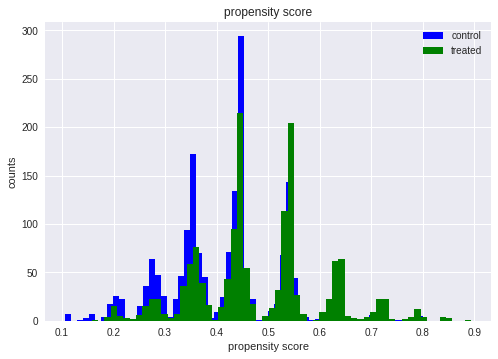

In [ ]:
control_e = trc[trc.TRCKNOW == 0].propensity_score
treat_e = trc[trc.TRCKNOW == 1].propensity_score
plt.style.use('seaborn')
plt.hist(control_e, bins = 60, color = 'blue', label = 'control')
plt.hist(treat_e, bins = 60, color = 'green', label = 'treated')
plt.title('propensity score')
plt.legend(loc = 'best')
plt.xlabel('propensity score')
plt.ylabel('counts')
plt.show()


The overlap in propensity score suggests that the treatment and comparison groups are well balanced in the matched or weighted samples. A balance of covariate is achieved. The conditional possitivity assumption holds since after conditioning on covariates, an individual has positive probability of belonging to eith the treated or the control group.

4. Assess post-weighting balance! Perform a t-test to compare the means of each covariate for the exposed and nonexposed respondents, using the IPTW weights you previously obtained. You should use the dedicated option in the ttest ind function.

`from statsmodels.stats.weightstats import ttest_ind`

`ttest_ind(x_treated , x_control , usevar='unequal ',
weights=(weights_treated , weights_control))`

In [ ]:
treated, control= trc[trc['TRCKNOW'] == 1], trc[trc['TRCKNOW'] == 0]
weights_treated, weights_control = treated.iptw.values, control.iptw.values
t_result_with_wt = {}
for covariate in covariates:
  x_treated, x_control = treated[covariate].values, control[covariate].values
  t, p, df = ttest_ind(x_treated, x_control, usevar = 'unequal', weights = (weights_treated, weights_control))
  t_result_with_wt[covariate] = [t, p, df]
t_result_with_wt
t_weighting_res = pd.DataFrame(np.array(list(t_result_with_wt.values())), columns = ['t_statistics', 'p', 'dof'], index = t_result_with_wt.keys())
t_weighting_res

,t_statistics,p,dof
female,-0.140195,0.888510,6409.527766
rcblack,0.410068,0.681770,6409.523339
rcwhite,-0.050613,0.959635,6409.522801
rccol,-0.354759,0.722782,6408.921693
age,-0.041628,0.966797,6396.373100
wealth,-0.112762,0.910222,6409.327576
religiosity,-0.012020,0.990410,6408.840403
ethsalience,0.052481,0.958147,6408.255948
EDUC,-0.294530,0.768362,6408.507225


Compare your results with what you obtained in Question 2. Do you think that the IPTW weights seem fine?

The IPTW weights seem fine since the p value gets larger, suggesting that the difference between the control and treated group is less significant.



## Question 4 (3 points)
Use the propensity score to construct an IPW estimator and report the point estimate for the ATE.


In [ ]:
point_wtd = np.mean(trc.iptw * trc.RUSTAND * trc.TRCKNOW - trc.iptw * trc.RUSTAND * (1- trc.TRCKNOW))
print(f'The IPW estimator is: {point_wtd}')

The IPW estimator is: -0.1624801679426361



##Question 5 (10 points)

Using a bootstrap (resampling individual rows of the data with replacement), obtain estimate for the standard error of your IPW estimator for the ATE. Compute a 95% confidence interval and interpret your findings. You should report estimate, Std, 95% CI lower, 95% CI upper, with the Std and CI obtained from the bootstrap empirical distribution. Compare your results in Questions 4 and 5 to your estimate from Question 1 and briefly discuss your findings.

In [ ]:
N = trc.shape[0]
N_boot=1000
ate_ipw_boot = np.empty(N_boot)
rg = np.random.default_rng(42)
for i in range(N_boot):
    idx_boot = rg.choice(N, N, replace=True)
    trc_boot = trc.loc[idx_boot]
    clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=10, solver='lbfgs')).\
            fit(trc_boot[covariates], trc_boot.TRCKNOW)
    trc_boot['e'] = clf.predict_proba(trc_boot[covariates])[:, 1]
    trc_boot.loc[trc_boot.TRCKNOW==0, 'wt'] = 1 / (1-trc_boot.loc[trc_boot.TRCKNOW==0, 'e'])
    trc_boot.loc[trc_boot.TRCKNOW==1, 'wt'] = 1 / (trc_boot.loc[trc_boot.TRCKNOW==1, 'e'])
    point_wtd = np.mean(trc_boot.wt * trc_boot.RUSTAND * trc_boot.TRCKNOW -
                        trc_boot.wt * trc_boot.RUSTAND * (1-trc_boot.TRCKNOW))
    ate_ipw_boot[i] = point_wtd

ate_ipw = np.mean(ate_ipw_boot)
scalar = norm.ppf(0.975)
std = np.std(ate_ipw_boot)
conf_interval = [ate_ipw - scalar * std , ate_ipw + scalar * std]
print(f'Bootstrap IPW estimate: {np.mean(ate_ipw)}\nStd of estimator:{std}\n95% Confidence Interval:{conf_interval}')

Bootstrap IPW estimate: -0.16490273113212764
Std of estimator:0.04549524161837562
95% Confidence Interval:[-0.2540717661720916, -0.07573369609216365]


Comparison: 

|    | ate                  | std                 | 95% CI                                      |   |
|----|----------------------|---------------------|---------------------------------------------|---|
| Q1 | -0.21773173612920127 | 0.04433111269216462 | [-0.3046191204004304, -0.13084435185797214] |   |
| Q4 | -0.1624801679426361  |                     |                                             |   |
| Q5 | -0.16490273113212764 | 0.04549524161837562 | [-0.2540717661720916, -0.07573369609216365] |   |

The IPW esitimate and the bootstrap IPW estimate of ATE is smaller than the difference in mean estimate. The inclusion of a sample weight in the regression model makes the dataset more balanced in terms of treatment distribution. The difference in mean estimator needs the strong ignorability assumption and may overestimate the effect of treatment.

# Exercise2
Use the same data set as in Exercise1. We already discussed the identifiability assumptions, and will admit that we can apply a matching estimator to estimate the ATE of TRC exposure respondents' racial attitudes.



## Question1:
Estimate the ATE of TRC exposure on respondents' racial attitudes using the Matching approach. You can use the `est_via_matching` function from causalinference package in python (as in Week 6 recitation), with the Mahalanobis Distance matching to get the matching data. Report 95\% confidence interval of your estimate.

In [ ]:
def matching_experiment(num_match = 1, bias_adjust = False):
  print(f'-------------matching {num_match} observation, bias adjustment is {bias_adjust}------------------')
  cm = CausalModel(
      Y = trc.RUSTAND.values,
      D = trc.TRCKNOW.values ,
      X = trc[covariates].values)
  cm.est_via_matching(weights='maha', matches = num_match, bias_adj = bias_adjust)
  ate = cm.estimates['matching']['ate']
  print(cm.estimates)
  print(f'The matching ate estimate is:{ate}')
matching_experiment()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
-------------matching 1 observation, bias adjustment is False------------------

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.180      0.072     -2.514      0.012     -0.320     -0.040
           ATC     -0.108      0.081     -1.328      0.184     -0.267      0.051
           ATT     -0.269      0.082     -3.285      0.001     -0.429     -0.108

The matching ate estimate is:-0.1799531981279251


## Question2:
Now estimate the ATE by matching to 3 observaions instead of 1 (which is the default in the `est_via_matchin` function). Did the Standard Error change compared to Question1?

In [ ]:
matching_experiment(num_match = 3)

-------------matching 3 observation, bias adjustment is False------------------

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.156      0.054     -2.862      0.004     -0.262     -0.049
           ATC     -0.123      0.059     -2.081      0.037     -0.239     -0.007
           ATT     -0.195      0.058     -3.346      0.001     -0.310     -0.081

The matching ate estimate is:-0.1556281108387193


When changing to matching 3 observations instead of 1, the standard error decreases as compared to part 1.

## Question3:
Now adjust for the bias due to inexact matching and compute the ATE estimate for both models (with 1 and 3 neighbors). Did the standard error decrease compared to the previous two parts?


In [ ]:
matching_experiment(num_match = 1, bias_adjust = True)
matching_experiment(num_match = 3, bias_adjust = True)

-------------matching 1 observation, bias adjustment is True------------------


/usr/local/lib/python3.7/dist-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.174      0.072     -2.435      0.015     -0.315     -0.034
           ATC     -0.101      0.081     -1.240      0.215     -0.260      0.058
           ATT     -0.265      0.082     -3.237      0.001     -0.425     -0.104

The matching ate estimate is:-0.17425725038769624
-------------matching 3 observation, bias adjustment is True------------------

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.148      0.054     -2.717      0.007     -0.254     -0.041
           ATC     -0.113      0.059     -1.904      0.057     -0.229      0.003
           ATT     -0.191      0.058     -3.265      0.001     

Even with the correction of bias of imperfect matches, The standard error does not decrease compared to the previous two parts.

# Exercise3 Weak instruments

In this exercise, we will conduct a simulation to access what happens when we use a weak instrument, i.e. when the correlation between the instrument and he treatment is low.

Let's consider the following Data Generating Process(DGP), with the normal distribution with mean $\mu$, and standard deviation $\sigma$ denoted as $N(\mu, \sigma^2)$

$$Z \sim N(0,1)$$
$$U \sim N(0,4)$$
$$\epsilon \sim N(0,4)$$
$$\upsilon \sim N(0,25)$$
$$T|Z, U \sim 1 + 0.5U + Z + \epsilon$$
$$Y|T,Z, U \sim 1- 0.5U + 2T + v$$

## Question1 Data generation

Write the code to simulate the $Z, U, T$ and $Y$ variable as specified above, for $N$ units. For all the exercises, we can use $N = 10000$

In [ ]:
rg = np.random.default_rng(123)
N = 10000
# scale is std
Z = rg.normal(loc=0, scale=1, size = N)
U = rg.normal(loc=0, scale=2, size = N)
epsilon = rg.normal(loc=0, scale=2, size = N)
upsilon = rg.normal(loc=0, scale=5, size = N)
T = 1 + 0.5*U + Z + epsilon
Y = 1 - 0.5*U + 2*T + upsilon

## Question2 IV estimation

To estimate a weak relationship between $Z$ and $T$, we will estimate our causal effect with instrument using a noisy version of the instrument, $\tilde{Z} = Z + \xi$, with $\xi \sim N(0, \sigma^2).$ We will vary the level of noise by varying the value of $\sigma$, for example using the following values `stddevs = np.linspace(0.1, 20, 50)`

Construct a loop, and at each iteration, construct the variable `Z_tilde`, and then use the `IV2SLS` function to get the ATE estimate and its standard error. Record those variables at each iteration, as well as the correlation between T and `Z_tilde`

In [ ]:
stddevs = np.linspace(0.1, 20, 50)
endog_list, se_list = [], []
for std in stddevs:
    epsilon = rg.normal(loc=0, scale=std, size = N)
    Z_tilde = Z + epsilon
    iv2sls = IV2SLS(dependent = Y, #outcome
       endog = T, #treatment
       exog = U,
       instruments = Z_tilde #Instrument
      ).fit(cov_type = "unadjusted")

    endog_list.append(iv2sls._params['endog'])
    se_list.append(np.sqrt(iv2sls._s2))
print(f'ate:{endog_list}')
print(f'std:{se_list}')
#dir(iv2sls)

ate:[2.0520154351467523, 2.0460353740343833, 2.0440596683716463, 2.0151880619630145, 1.9315978990772713, 1.9914390611796788, 2.056285394638488, 2.13175710492097, 2.077192431163642, 2.1111536402107234, 1.897988653337407, 1.931725337522753, 2.1534483801940993, 2.248617545396929, 2.256273068465994, 1.898101335114177, 1.8286496874719234, 2.460508433439898, 1.826189595253588, 2.1904565772757962, 1.392358369319112, 2.6741589806417636, 2.6690510004006853, 2.201652401100425, 2.655567567769907, 2.145063566469503, 2.186606897551627, 0.8554436686759743, 1.45256838465545, 1.4649244619193098, 2.7164043436824556, 2.891101641976263, 0.8104927934881516, 0.7894029487611078, 1.8715664730952994, 1.8268768375008904, 1.020685825178873, 0.736356701490763, 2.9680014740623335, 1.122356912468149, 2.446450291220458, 2.069551887723833, 2.9879868191631545, 1.9049465280147615, 4.445511259254772, 1.6075437966147774, 0.7923951565784364, 2.155182702412276, 2.442828419725771, 2.118950533662428]
std:[5.120369889483651,

##Question 3 Plot the results

Let’s now represent the ATE estimate and its standard error as a function of the
correlation between T and Z as two distinct scatter plots.

In [ ]:
stddevs = np.linspace(0.1, 20, 50)
ate_list, se_list, corr = [], [], []
for std in stddevs:
    epsilon = rg.normal(loc=0, scale=std, size = N)
    Z_tilde = Z + epsilon
    corr.append(np.corrcoef(T, Z_tilde)[0][1])
    iv2sls = IV2SLS(dependent = Y, #outcome
       endog = T, #treatment
       exog = U,
       instruments = Z_tilde #Instrument
      ).fit(cov_type = "unadjusted")

    ate_list.append(iv2sls._params['endog'])
    se_list.append(np.sqrt(iv2sls._s2))
print(f'ate:{ate_list}')
print(f'std:{se_list}')
print(f'corr:{corr}')


ate:[2.052908814396991, 2.0736069117904012, 2.0141207038642817, 2.1607852943243153, 2.0765436879445605, 2.233984061018247, 1.9995830676518986, 2.0621912290307574, 1.9507986320317343, 1.9511371538633213, 2.4460790803809687, 1.7571314623055336, 1.7954752977780224, 1.8687991682185512, 2.144592679717512, 1.8170393240714162, 2.2688170343652914, 2.4019903538637237, 1.8035553751995366, 2.0366944194211527, 2.486047604654246, 2.056483826959976, 2.5656468744880954, 2.509532858890182, 2.5236244478430194, 2.4399408074686733, 2.7658750255029645, 1.7970765803499376, 2.1214094718528997, 0.8901223725502518, 0.7343303842718001, 3.2928648780294054, 2.278988726911791, 1.652982135266484, 2.481462996880225, 2.143321372421937, 1.8980396614567212, 0.3560417700551852, 2.0989156882773727, 0.5529383265382535, 0.13218836115083832, 2.710883988892135, 3.0012586181931056, 2.1116835512886496, 1.359121122297438, 2.130221840072508, 3.322859309488649, 0.8447036525711837, 2.256657045922225, 3.56276839404552]
std:[5.1202

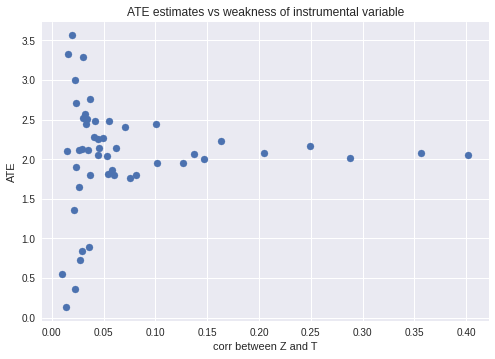

In [ ]:
plt.style.use('seaborn')
plt.scatter(corr, ate_list)
plt.xlabel('corr between Z and T')
plt.ylabel('ATE')
plt.title('ATE estimates vs weakness of instrumental variable')
plt.show()

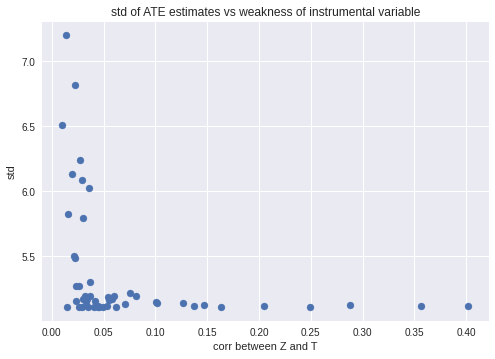

In [ ]:
plt.scatter(corr, se_list)
plt.xlabel('corr between Z and T')
plt.ylabel('std')
plt.title('std of ATE estimates vs weakness of instrumental variable')
plt.show()

## Question 4 Conclusion
What can you observe on those plots. Conclude.

As we increase the noise of instrument variable $Z$, the correlation between $Z$ and treatment $T$ decreases. The ATE estimates starts to deviate more from the true value 2 (coefficent of T in data simulation). The standard deviation of the ATE estimate also increase and deviates from the true std 5 (std of upsilon in data simulation). The result suggests that the ATE estimates is more accurate and has a narrower confidence interval when the instumental variable has a stronger determination on treatment.